In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable
from sklearn.metrics import mutual_info_score

class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden,1)
        
    def forward(self, x):
        t = F.relu(self.fc1(x))
        y = F.sigmoid(self.fc2(t))
        return t, y

In [3]:
def rand_n_sphere(r, alpha):
    """alpha: the n-2 values between [0,\pi) and last one between [0,2\pi)
    """
    x = np.zeros(len(alpha) + 1)
    s = 1
    for e, a in enumerate(alpha):
        x[e] = s*np.cos(a)
        s *= np.sin(a)
    x[len(alpha)] = s
    return x*r

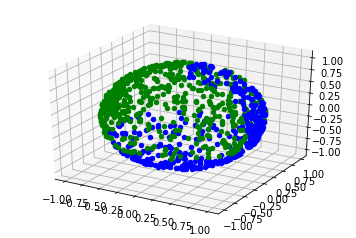

In [4]:
n = 4
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

for i in range(1000):
    color = 'g'
    alpha = np.pi * np.random.rand(n - 2)
    alpha[-1] = 2* alpha[-1]

    x = rand_n_sphere(1, alpha)
        
    if x[0] > 0 and x[1] < 0.5 and x[1] > -0.2 or x[2] < -0.4: 
        color = "b" 
    ax.scatter(x[0], x[1], x[2], c = color)

plt.show()

In [5]:
n = 10
input_size = 5000

x = np.zeros((input_size, n))
y = np.zeros((input_size,))

for i in range(input_size):
    alpha = np.random.rand(n - 1) * np.pi
    alpha[-1] = 2* alpha[-1]

    x[i,:] = rand_n_sphere(1, alpha)
    
#    if x[i,0] > 0 and x[i,1] < 0.5 and x[i,1] > -0.2 or x[i,2] < -0.4:
#        y[i] = 1            
    
#y = np.random.randint(1, size = input_size) + 1


In [18]:
#Perceptron classification

def sigmoid(x):
    return 1/(1 + np.exp(x))

def random_perceptron(x):
    W = np.random.rand(n, 1)
    b = np.random.rand(1)

    return sigmoid(x.dot(W) + b)


In [11]:
# Convert numpy to torch tensors

x = torch.from_numpy(x)
y = torch.from_numpy(y)
x,y = x.type(torch.FloatTensor),y.type(torch.FloatTensor)

RuntimeError: from_numpy expects an np.ndarray but got torch.FloatTensor

In [16]:
train_input, train_target = Variable(x[:int(input_size*0.7), :]), Variable(y[:int(input_size*0.7)])

nb_hidden = 15
nb_bins = 20
nb_epochs = 40


model, criterion = Net(nb_hidden), nn.MSELoss()
eta, mini_batch_size = 1e-1, 100

MI = np.zeros((nb_epochs,))

for e in range(0, nb_epochs):
    sum_loss = 0
    hist = np.zeros((nb_hidden, nb_bins)) #create histogram to store occurrance of each hidden node value in each bin
    # We do this with mini-batches
    for b in range(0, train_input.size(0), mini_batch_size):
        t, output = model.forward(train_input.narrow(0, b, mini_batch_size))
        loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
        sum_loss = sum_loss + loss.data[0]
        model.zero_grad()
        loss.backward()
        for p in model.parameters():
            p.data.sub_(eta * p.grad.data)
        
        #Divide output of hidden layer into bins for one epoch, hist has 20
        hist += np.array([np.histogram(s, bins = nb_bins)[0] for s in t.data.numpy().T])
    
    MI[e] = mutual_info(hist, nb_hidden)
    
    print(e, sum_loss)

0 0.5032200459390879
1 0.4472363954409957
2 0.4098249888047576
3 0.3798803687095642
4 0.3534534079954028
5 0.32919243164360523
6 0.306619665119797
7 0.2855067481286824
8 0.2657966543920338
9 0.24751192703843117
10 0.2305781813338399
11 0.21496586874127388
12 0.2006457457318902
13 0.18756816256791353
14 0.17565147415734828
15 0.16478465008549392
16 0.15487238531932235
17 0.14583387761376798
18 0.13759118714369833
19 0.1300656741950661
20 0.12317027593962848
21 0.11683919187635183
22 0.11102580069564283
23 0.10567341046407819
24 0.10073448880575597
25 0.09617246477864683
26 0.09194989269599319
27 0.08803346566855907
28 0.08439641783479601
29 0.08100359106902033
30 0.07783306366764009
31 0.07487552566453815
32 0.07211107411421835
33 0.069521622848697
34 0.06708386249374598
35 0.06477877136785537
36 0.06260131008457392
37 0.060538132092915475
38 0.05858462245669216
39 0.05673301650676876


In [14]:
# Given histogram matrix (num of hidden layers) x (num bins)
# gives mutual information as sum on number of layers of entropy

def mutual_info(hist, nb_hidden):
    MI = 0

    for i in range(nb_hidden):
        #plt.figure(i)
        #plt.title(str(i))
        #plt.bar(range(nb_bins), hist[i,:])
        p = hist[i,:] / (np.sum(hist[i,:]) * hist.shape[0]) + 1e-8 # add sth small to avoid Nan in log
        MI -= np.sum(np.multiply(p, np.log(p)))

    return MI



In [17]:
MI

array([4.63509821, 4.61934734, 4.60388467, 4.59372919, 4.58542906,
       4.57933832, 4.57371283, 4.57080386, 4.5687247 , 4.56457431,
       4.56115661, 4.56563963, 4.56377064, 4.56168973, 4.55960942,
       4.55915444, 4.55772664, 4.55644338, 4.55395914, 4.55335674,
       4.55202063, 4.55123964, 4.55248295, 4.5521439 , 4.5525325 ,
       4.55295367, 4.5535031 , 4.55396695, 4.5544516 , 4.55494699,
       4.5558921 , 4.55610938, 4.55574879, 4.55587279, 4.55690663,
       4.55765463, 4.55852364, 4.55931631, 4.56051622, 4.56137633])

In [ ]:
test_input, test_target = Variable(x[int(input_size*0.7):, :]), Variable(y[int(input_size*0.7):])


_, output = model.forward(test_input)
output = torch.round(output).view(-1)

errors = (torch.abs(output - test_target)).sum()

print("Test error = ", float(errors / test_target.shape[0] * 100), "%")

In [ ]:
[i for i in t.data.numpy()]
